CNNs

# New section

In [ ]:
import os
import re
import io
import requests
import torch
import numpy as np
import pandas as pd
import spacy
!pip install emoji
from emoji import demojize
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
!pip install torchmetrics
!pip install torcheval
from torchmetrics.classification import MulticlassF1Score
from torcheval.metrics.functional import multiclass_f1_score
import torch.optim as optim
from torch import autograd
import random
!pip install ray
!pip install torchmetrics
from ray import tune
from ray.tune import CLIReporter
import string
exclude = string.punctuation

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

from nltk import word_tokenize, pos_tag
from collections import Counter
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(1)


import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 13.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nlp = spacy.blank("en")
%matplotlib inline

In [ ]:
# use the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


Importing and converting data into dataframe

In [ ]:
!git clone https://github.com/cardiffnlp/tweeteval.git

Cloning into 'tweeteval'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 370 (delta 13), reused 3 (delta 1), pack-reused 354
Receiving objects: 100% (370/370), 8.49 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
def load_text(path):

    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

In [ ]:
train_text = load_text("/content/tweeteval/datasets/emotion/train_text.txt")
train_labels = load_text("/content/tweeteval/datasets/emotion/train_labels.txt")
test_text = load_text("/content/tweeteval/datasets/emotion/test_text.txt")
test_labels = load_text("/content/tweeteval/datasets/emotion/test_labels.txt")
val_text = load_text("/content/tweeteval/datasets/emotion/val_text.txt")
val_labels = load_text("/content/tweeteval/datasets/emotion/val_labels.txt")

In [ ]:
train_data = list(zip(train_text,train_labels))
test_data = list(zip(test_text,test_labels))
val_data = list(zip(val_text,val_labels))

df_train = pd.DataFrame(train_data,columns=["tweet","label"])
df_test = pd.DataFrame(test_data,columns=["tweet","label"])
df_val = pd.DataFrame(val_data,columns=["tweet","label"])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3257 non-null   object
 1   label   3257 non-null   object
dtypes: object(2)
memory usage: 51.0+ KB


In [ ]:

print('There are {} tweets labeled 0'.format(len(df_train[df_train["label"].isin(['0'])])))
print('There are {} tweets labeled 1'.format(len(df_train[df_train["label"].isin(['1'])])))
print('There are {} tweets labeled 2'.format(len(df_train[df_train["label"].isin(['2'])])))
print('There are {} tweets labeled 3'.format(len(df_train[df_train["label"].isin(['3'])])))



There are 1400 tweets labeled 0
There are 708 tweets labeled 1
There are 294 tweets labeled 2
There are 855 tweets labeled 3


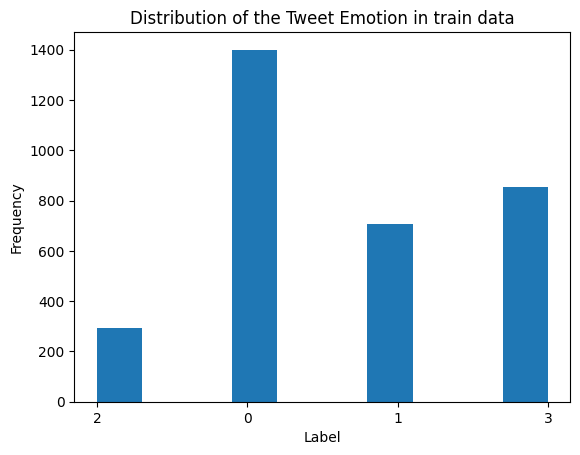

In [ ]:
#plotting the frequency distribution of the tweet emotion
import matplotlib.pyplot as plt

plt.hist(df_train["label"])
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Distribution of the Tweet Emotion in train data")
plt.show()

Data Preprocessing

In [ ]:
# data preprocessing class
class Preprocessing:

  # lowercasing
  def convert_lowercase(self,text):
      text = text.lower()
      return text

  # removing html tags
  def remove_html_tags(self,text):
      re_html = re.compile('<.*?>')
      return re_html.sub(r'', text)

  # removing URLS
  def remove_url(self,text):
      re_url = re.compile('https?://\S+|www\.\S+')
      return re_url.sub('', text)

  # removing punctuations
  def remove_punc(self,text):
      return text.translate(str.maketrans('', '', exclude))

  # removing special characters
  def remove_special(self,text):
      x=''
      for i in text:
          if i.isalnum():
              x=x+i
          else:
              x=x+' '
      return x

  # removing digits
  def remove_digits(self,text):
      filtered_string = ''.join((x for x in text if not x.isdigit()))
      return filtered_string

  def demojize(self,text):
      return demojize(text)

  # removing stop words
  def remove_stopwords(self,text):
      new_text = []
      for word in text.split():
          if word in stopwords_english:
              continue
          else:
              new_text.append(word)

      return ' '.join(new_text)

  def preprocess(self,text):
    full_text = []
    for sent in text:
      sent = self.convert_lowercase(sent)
      sent = self.remove_html_tags(sent)
      sent = self.remove_url(sent)
      sent = self.remove_digits(sent)
      sent = self.remove_punc(sent)
      sent = self.remove_special(sent)
      sent = self.remove_stopwords(sent)
      sent = self.demojize(sent)
      full_text.append(sent)
    return full_text

Data tokentization and encoding

In [ ]:
# function for text tokentization

def tokenize(texts):
  max_len = 0
  tokenized_texts = []
  word2idx = {}

  # Add <pad> and <unk> tokens to the vocabulary
  word2idx['<pad>'] = 0
  word2idx['<unk>'] = 1

  # Building our vocab from the corpus starting from index 2
  idx = 2
  for sent in texts:
    tokenized_sent = nlp(sent)
    # Add `tokenized_sent` to `tokenized_texts`
    tokenized_texts.append(tokenized_sent)
    # Add new token to `word2idx`
    for token in tokenized_sent:
      # string any token objects are different things, be careful.
      if token.text not in word2idx:
        word2idx[token.text] = idx
        idx += 1

        # Update `max_len`
    max_len = max(max_len, len(tokenized_sent))

  return tokenized_texts, word2idx, max_len

In [ ]:
# function for converting words into numeric ids
def encode(tokenized_texts, word2idx, max_len):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_padded_sent = list(tokenized_sent) + ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids, assign value 1 if word doesn't exist in vocabulary
        input_id = [word2idx.get(str(token)) if str(token) in word2idx else 1 for token in tokenized_padded_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

Model

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=4,
                 dropout=0.5):

        super(CNN, self).__init__()
        # Random Embedding layer
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), 4)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
# Our model class have preprocessing, encoding, data loader and train_model functions
class model_emotions:
  def __init__(self):
    pass

  # Takes training data and returns the processed tensor of input data and its labels
  # Also returns the word2idx dictionary for validation and test data preprocessing
  def get_train_tokenizors(self,train_data):
    self.train_data = train_data
    preprocessed_text_train = Preprocessing().preprocess(self.train_data["tweet"])
    tokenized_texts, word2idx, max_len = tokenize(preprocessed_text_train)
    input_ids_train = encode(tokenized_texts, word2idx, max_len)

    # train label encoders
    label_encoder = LabelEncoder()
    train_data_labels = label_encoder.fit_transform(self.train_data["label"])


    #convert train inputs and labels to torch tensor

    train_inputs = torch.from_numpy(input_ids_train)
    labels_train = torch.from_numpy(train_data_labels)

    return word2idx, max_len, train_inputs, labels_train

  # returns the validation or test tensors
  def get_processed_data(self,data,word2idx,max_len):
    # preprocess the training and the validation data- learn the vocabulary from the training data and only encode the validation data
    preprocessed_text = Preprocessing().preprocess(data["tweet"])
    input_ids = encode([nlp(sent) for sent in preprocessed_text], word2idx, max_len)

    # label encoders

    label_encoder = LabelEncoder()
    data_labels = label_encoder.fit_transform(data["label"])

    # Convert data type to torch.Tensor for input_ids and data_labels

    inputs = torch.from_numpy(input_ids)
    labels_data = torch.from_numpy(data_labels)

    return inputs, labels_data

  # takes the tensors and returns the DataLoader of training data
  def get_dataloader(self,train_data_tensor,labels_train_tensor,batch_size):

    # Specify batch_size
    self.batch_size = batch_size

    # Create DataLoader for training data
    train_data = TensorDataset(train_data_tensor, labels_train_tensor)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return train_dataloader

  # train the model
  def train_model(self,config):

    train_data = config["train_data"]
    val_data = config["val_data"]


    # get the tensorial forms of the train and validation data
    word2idx,max_len,inputs_train,labels_train = self.get_train_tokenizors(train_data)
    inputs_val, labels_val = self.get_processed_data(val_data,word2idx,max_len)

    batch_size = config["batch_size"]


    model = CNN(vocab_size = len(word2idx),
                 embed_dim = 300,
                 filter_sizes = config["filter_sizes"],
                 num_filters = config["num_filters"],
                 num_classes = 4,
                 dropout = config["dropout"])


    model = model.to(device)

    # testing Adam and Adadelta optimizers

    # optimizer = optim.Adadelta(model.parameters(),
    #                            lr = config["lr"],
    #                            rho = 0.95)


    optimizer = optim.Adam(model.parameters(),
                              lr = config["lr"])


    loss_fn = nn.CrossEntropyLoss()

    # get the dataloader
    train_dataloader = self.get_dataloader(inputs_train,labels_train,batch_size)

    train_loss_per_epoch = []
    val_loss_per_epoch = []

    epochs = 10
    mean_val_acc = 0

    # train the model on the training data
    for epoch_i in range(epochs):
      total_loss = 0
      # Put the model into the training mode
      model.train()
      for step, batch in enumerate(train_dataloader):
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)
        b_labels = b_labels.type(torch.LongTensor)
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        # Zero out any previously calculated gradients
        model.zero_grad()
        # Perform a forward pass. This will return logits.
        logits = model(b_input_ids)
        # Compute loss and accumulate the loss values
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()
        # Perform a backward pass to calculate gradients
        loss.backward()
        # Update parameters
        optimizer.step()

      # Calculate the average loss over the entire training data
      avg_train_loss = total_loss / len(train_dataloader)
      train_loss_per_epoch.append(avg_train_loss)

      # test the model on the validation data
      model.eval()
      val_data, val_labels = inputs_val.to(device), labels_val.type(torch.LongTensor).to(device)
      val_labels_pred = model(val_data)
      val_loss = loss_fn(val_labels_pred,val_labels)
      val_loss = val_loss.item()
      val_loss_per_epoch.append(val_loss)

      # validation accuracy
      val_accuracy = (torch.argmax(val_labels_pred, dim = 1) == val_labels).sum().item() / len(val_labels)
      mean_val_acc += val_accuracy / epochs

      #f1 score on validation data
      f1_score_val = multiclass_f1_score(val_labels_pred, val_labels, average="macro",num_classes=4).to(device)

    # adding this to configuration as ray doesn't work if function returns values
    # we only need validation loss and accuracy for hyperparameter tuning
    if config["train"]==True:
      train.report({'loss': val_loss, 'accuracy': mean_val_acc, 'f1_score': f1_score_val.item()})
  #this will send validation loss and accuracy to Tune
    else:

      return word2idx, max_len, model

In [ ]:

import torch.optim as optim
from ray import train

config = {"train_data":df_train,"val_data":df_val,
          "batch_size":tune.grid_search([8,16,24]),
          "filter_sizes":[3,4,5],
          "num_filters":tune.grid_search([[100,100,100],[150,150,150]]),
          "dropout":tune.choice([0.5,0.6,0.8]),
          "lr": tune.grid_search([0.1, 0.001, 0.01]),
          "train": True
          }

reporter = CLIReporter(
        metric_columns=["accuracy", "loss", "f1_score"])

##### getting the best hyperparameters for label 0 and 1 model ######
analysis = tune.run(model_emotions().train_model,
                    config=config,
                    verbose=3,
                    resources_per_trial = {'gpu': 1, 'cpu': 2 },
                    progress_reporter = reporter,
                    resume = 'AUTO',
                    )

print("Best config: ", analysis.get_best_config("f1_score", "max"))

# Get a dataframe for analyzing trial results.
df1 = analysis.dataframe()

2023-10-17 19:42:25,813	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-10-17 19:42:25,819	INFO registry.py:107 -- Detected unknown callable for trainable. Converting to class.
2023-10-17 19:42:25,861	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2023-10-17 19:42:25,863	WARNING tune.py:997 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.
2023-10-17 19:42:25,869	INFO experiment_state.py:524 -- No local checkpoint was found. Ray Tune will now start a new experiment.


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2023-10-17_19-42-25   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 18                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2023-10-17_19-42-25

Trial status: 16 PENDING
Current time: 2023-10-17 19:42:31. Total running time: 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+-----------------------------------------------------------------------------------------+
| Trial name                status       dropout     batch_size   num_filters          lr |
+----------------------------------------------------------------------------

(pid=2755) 2023-10-17 19:42:38.452609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                  8 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                        0.1 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00000 finished iteration 1 at 2023-10-17 19:42:57. Total running time: 31s
+------------------------------------------------

(pid=2927) 2023-10-17 19:43:04.111183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                        0.1 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00001 finished iteration 1 at 2023-10-17 19:43:18. Total running time: 52s
+------------------------------------------------

(pid=3082) 2023-10-17 19:43:29.450397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial status: 2 TERMINATED | 16 PENDING
Current time: 2023-10-17 19:43:31. Total running time: 1min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         dropout     batch_size   num_filters          lr     iter     total time (s)      loss     accuracy     f1_score |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_4c6ec_00000   TERMINATED         0.6              8   [100, 100, 100]   0.1          1            16.8675   692.174     0.450267     0.371838 |
| train_model_4c6ec_00001   TERMINATED         0.6             16   [100, 100, 100]   0.1          1            10.8714   408.001     0.471123     0.435003 |
| train_model_4c6ec_00002  

(pid=3226) 2023-10-17 19:43:47.140542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                  8 |
| dropout                                                   0.8 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                      0.001 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial status: 3 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2023-10-17 19:44:01. Total running time: 1min 35s
Logical resource usage: 2.0/2 CP

(pid=3407) 2023-10-17 19:44:14.259130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                      0.001 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00004 finished iteration 1 at 2023-10-17 19:44:26. Total running time: 2min 0s
+--------------------------------------------

(pid=3552) 2023-10-17 19:44:35.311785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 24 |
| dropout                                                   0.5 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                      0.001 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00005 finished iteration 1 at 2023-10-17 19:44:45. Total running time: 2min 19s
+-------------------------------------------

(pid=3695) 2023-10-17 19:45:03.686587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                  8 |
| dropout                                                   0.5 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00006 finished iteration 1 at 2023-10-17 19:45:27. Total running time: 3min 1s
+--------------------------------------------

(pid=3928) 2023-10-17 19:45:36.737784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| dropout                                                   0.5 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00007 finished iteration 1 at 2023-10-17 19:45:49. Total running time: 3min 23s
+-------------------------------------------

(pid=4087) 2023-10-17 19:45:56.272023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00008 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00008 config                          |
+---------------------------------------------------------------+
| batch_size                                                 24 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [100, 100, 100] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial status: 8 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2023-10-17 19:46:01. Total running time: 3min 36s
Logical resource usage: 2.0/2 CPU

(pid=4216) 2023-10-17 19:46:12.886648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00009 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00009 config                          |
+---------------------------------------------------------------+
| batch_size                                                  8 |
| dropout                                                   0.8 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                        0.1 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial status: 9 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-10-17 19:46:32. Total running time: 4min 6s
Logical resource usage: 2.0/2 CPUs

(pid=4439) 2023-10-17 19:46:52.707385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00010 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00010 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                        0.1 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial status: 10 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-10-17 19:47:02. Total running time: 4min 36s
Logical resource usage: 2.0/2 CP

(pid=4584) 2023-10-17 19:47:15.168001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00011 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00011 config                          |
+---------------------------------------------------------------+
| batch_size                                                 24 |
| dropout                                                   0.5 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                        0.1 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00011 finished iteration 1 at 2023-10-17 19:47:24. Total running time: 4min 58s
+-------------------------------------------

(pid=4731) 2023-10-17 19:47:32.074052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial status: 12 TERMINATED | 6 PENDING
Current time: 2023-10-17 19:47:32. Total running time: 5min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         dropout     batch_size   num_filters          lr     iter     total time (s)         loss     accuracy     f1_score |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_4c6ec_00000   TERMINATED         0.6              8   [100, 100, 100]   0.1          1           16.8675     692.174       0.450267     0.371838 |
| train_model_4c6ec_00001   TERMINATED         0.6             16   [100, 100, 100]   0.1          1           10.8714     408.001       0.471123     0.435003 |
| train_mode

(pid=4906) 2023-10-17 19:47:59.958139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial status: 13 TERMINATED | 5 PENDING
Current time: 2023-10-17 19:48:02. Total running time: 5min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         dropout     batch_size   num_filters          lr     iter     total time (s)         loss     accuracy     f1_score |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_4c6ec_00000   TERMINATED         0.6              8   [100, 100, 100]   0.1          1           16.8675     692.174       0.450267     0.371838 |
| train_model_4c6ec_00001   TERMINATED         0.6             16   [100, 100, 100]   0.1          1           10.8714     408.001       0.471123     0.435003 |
| train_mod

(pid=5053) 2023-10-17 19:48:18.962481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00014 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00014 config                          |
+---------------------------------------------------------------+
| batch_size                                                 24 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                      0.001 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00014 finished iteration 1 at 2023-10-17 19:48:30. Total running time: 6min 4s
+--------------------------------------------

(pid=5188) 2023-10-17 19:48:37.071191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00015 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00015 config                          |
+---------------------------------------------------------------+
| batch_size                                                  8 |
| dropout                                                   0.8 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00015 finished iteration 1 at 2023-10-17 19:48:59. Total running time: 6min 33s
+-------------------------------------------

(pid=5375) 2023-10-17 19:49:09.258906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00016 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00016 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| dropout                                                   0.5 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial train_model_4c6ec_00016 finished iteration 1 at 2023-10-17 19:49:22. Total running time: 6min 56s
+-------------------------------------------

(pid=5527) 2023-10-17 19:49:29.018446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_model_4c6ec_00017 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_4c6ec_00017 config                          |
+---------------------------------------------------------------+
| batch_size                                                 24 |
| dropout                                                   0.6 |
| filter_sizes                                        [3, 4, 5] |
| lr                                                       0.01 |
| num_filters                                   [150, 150, 150] |
| train                                                    True |
| train_data                               ...rows x 2 columns] |
| val_data                                 ...rows x 2 columns] |
+---------------------------------------------------------------+

Trial status: 17 TERMINATED | 1 RUNNING
Current time: 2023-10-17 19:49:32. Total running time: 7min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPU

In [ ]:
# model with the best parameters for dataset 1
word2idx,max_len,label_01_model = model_emotions().train_model(config = {"train_data":df_train,"val_data":df_val,
                                                                        "batch_size": 24,
                                                                        "filter_sizes":[3,4,5],
                                                                        "num_filters":[100,100,100],
                                                                        "dropout":0.5,
                                                                        "lr": 0.001,
                                                                         "train":False})

# test the data
test_data_processed,test_labels = model_emotions().get_processed_data(df_test, word2idx, max_len)
test_data_processed = test_data_processed.to(device)
test_labels = test_labels.to(device)
test_label_predicted = label_01_model(test_data_processed)

# Accuracy of model on test_data
accuracy = torch.mean((torch.argmax(test_label_predicted, dim=1) == test_labels).float())
print("The test accuracy of the model is {}".format(accuracy))

# F1-Macro on test_data

f1_score_model = multiclass_f1_score(test_label_predicted, test_labels, average="macro",num_classes=4).to(device)
print("The f1-score of the model is {}".format(f1_score_model))

The test accuracy of the model is 0.5847994089126587
The f1-score of the model is 0.5379133224487305
